In [1]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

%matplotlib inline


In [2]:
# E-step
def EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec):
    '''
    y[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(y)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = norm.pdf(y)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, y):

    lambda_vec = sp.empty(k_size)
    #mu_vec = sp.empty(k_size)
    coef_vec = []
    sigma2_vec = sp.empty(k_size)
    

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        
        #coef_vec[k] = np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y
        coef_vec.append(np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y)
        
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        
        #mu_vec[k] = sp.sum(r_k * y) / sp.sum(r_k)
        
        sigma2_vec[k] = sp.sum(r_k * (y - np.mean(X@coef_vec[k]))**2) / sp.sum(r_k)
        
    mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
        
        
        

    return lambda_vec, mu_vec, coef_vec, sigma2_vec

In [3]:
def calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

# データの作成

In [4]:
df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

In [5]:
df.head()

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,1,108641,303.14
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,83,17.9,1,303691,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
4,Australia,24992369,86.012,51663.365095,7.608913e+06,8.62,9.160533,8.07,26,97.3,1,1347,75667.65


### スケーリング(標準化)

In [6]:
sscaler = preprocessing.StandardScaler() # インスタンスの作成

sscaler.fit(df[["hf", "pop",  "urb", "gdp","dist", "air", "detection"]])           # xの平均と分散を計算
X = sscaler.transform(df[["hf", "pop",  "urb", "gdp","dist", "air", "detection"]]) # xを変換

In [7]:
"""y=np.log(df["date_first"]).values
X = df[["hf", "pop",  "urb", "gdp","dist", "air", "detection"]].values
X = np.log(X)
X = np.insert(X, 0, 1, axis=1)"""

y=df["date_first"].values
#X = df[["hf", "pop",  "urb", "gdp","dist", "air", "detection"]].values
#X = np.log(X)
X = np.insert(X, 0, 1, axis=1)
pd.DataFrame(X, columns=["切片", "hf", "pop",  "urb", "gdp","dist", "air", "detection"])

,切片,hf,pop,urb,gdp,dist,air,detection
0,1.0,0.857976,-0.309387,-0.052302,-0.427358,-0.358821,-0.297413,1.166587
1,1.0,-1.762477,0.021782,0.509726,-0.336308,0.169300,-0.219741,-1.640901
2,1.0,-1.385500,-0.074288,0.184882,-0.724538,0.514881,-0.300275,-1.375023
3,1.0,-0.043092,0.040847,1.388198,-0.115791,2.649498,-0.282060,1.193625
4,1.0,1.575153,-0.123232,1.120744,1.219356,-0.205671,0.656070,2.203059
...,...,...,...,...,...,...,...,...
145,1.0,-2.856631,-0.090606,1.221005,-0.223628,1.657264,-0.274202,-1.789612
146,1.0,-0.567183,0.470316,-1.166315,-0.681737,-1.553198,0.294006,0.405005
147,1.0,-2.396903,-0.093732,-1.133305,-0.891243,-0.614905,-0.296993,-1.776093
148,1.0,-0.383291,-0.187515,-0.819236,-0.820352,0.313666,-0.301136,-1.194767


(array([0.0030303 , 0.01060606, 0.00378788, 0.00075758, 0.00530303,
        0.03181818, 0.02651515, 0.025     , 0.00530303, 0.00151515]),
 array([ 14. ,  22.8,  31.6,  40.4,  49.2,  58. ,  66.8,  75.6,  84.4,
         93.2, 102. ]),
 <a list of 10 Patch objects>)

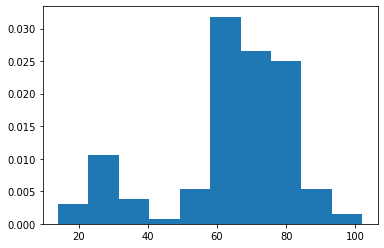

In [8]:
plt.hist(y, density=True)

# 初期値の設定  
- Rで計算済み

In [9]:
# 早期感染国のβ
coef1_first = [21.790, 0.994, 0.000, -0.014, 0.000, 0.000, 0.000, -0.124]
#coef1_first = [-0.737, -0.331,0.041,0.258,-0.117,0.386,-0.106,-0.162]

# 晩期感染国のβ
coef2_first = [93.920, -0.915, 0.000, -0.213, 0.000, 0.000, 0.000, -0.116]
#coef2_first = [5.383,-0.014,-0.030,-0.073,-0.058,0.023,0.001,-0.046]

first_df = pd.DataFrame(coef1_first, columns=["早期感染国β(初期値)"], index=["Intercept", "hf", "pop",  "urb", "gdp","dist", "air", "detection"])
first_df["晩期感染国β(初期値)"] = coef2_first
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,21.790,93.920
hf,0.994,-0.915
pop,0.000,0.000
urb,-0.014,-0.213
gdp,0.000,0.000
dist,0.000,0.000
air,0.000,0.000
detection,-0.124,-0.116


### sigmaの初期値設定方法は要検討

In [10]:
# muの初期値の計算
# mu = βx
mu1_first = np.mean(X@coef1_first)
mu2_first = np.mean(X@coef2_first)

# データを早期、晩期に分割
"""y_early = np.log(df["date_first"][df["date_first"]<40])
y_late = np.log(df["date_first"][df["date_first"]>40])"""
y_early = df["date_first"][df["date_first"]<40]
y_late = df["date_first"][df["date_first"]>40]

# sigmaの初期値
sigma1_first = np.sum((y_early - np.mean(y_early))**2)/len(y_early)
sigma2_first = np.sum((y_late - np.mean(y_late))**2)/len(y_late)

"""sigma1_first = np.sum((y - np.mean(y))**2)/len(y)
sigma2_first = np.sum((y - np.mean(y))**2)/len(y)"""

'sigma1_first = np.sum((y - np.mean(y))**2)/len(y)\nsigma2_first = np.sum((y - np.mean(y))**2)/len(y)'

In [11]:
# 混合正規分布の数
k_size = 2

# 正規分布の割合
lambda_vec=[0.5, 0.5]

# 説明変数のパラメータ
mu_vec = [mu1_first, mu2_first]

# 分散(sigma)の初期値
sigma2_vec=[sigma1_first, sigma2_first]

# coefの初期値
coef_vec = [coef1_first, coef2_first]

In [12]:
print("f1の混合比率", lambda_vec[0])
print("mu1", mu_vec[0])
print("sigma1", sigma2_vec[0])

f1の混合比率 0.5
mu1 21.79
sigma1 27.16824196597353


In [13]:
print("f2の混合比率", lambda_vec[1])
print("mu2", mu_vec[1])
print("sigma2", sigma2_vec[1])

f2の混合比率 0.5
mu2 93.92
sigma2 100.76979353958708


### 初期値から生成される分布の確認

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


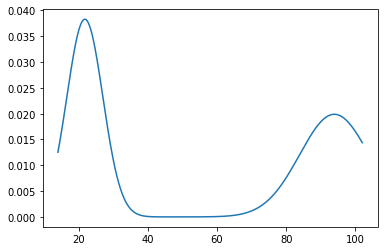

In [14]:
# データ(-6から6までを200こ)
x = sp.linspace(np.min(y), np.max(y), 10000)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

# EMアルゴリズム

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and

i: 0 lambda [0.15647506 0.84352494] mu [38.73451340411457, 68.84911714762767] sigma2 [156.02311295 101.54805716]
i: 5 lambda [0.47640074 0.52359926] mu [61.348580511296944, 68.41336724776113] sigma2 [562.08194355  65.40383806]
i: 10 lambda [0.47771354 0.52228646] mu [61.3952806425119, 68.37301654025318] sigma2 [564.07759657  64.1387756 ]
i: 15 lambda [0.4777327 0.5222673] mu [61.39586514291777, 68.37251085043987] sigma2 [564.09920817  64.12333195]
i: 20 lambda [0.47773293 0.52226707] mu [61.39587237112086, 68.37250459392965] sigma2 [564.09947486  64.12314106]
i: 25 lambda [0.47773294 0.52226706] mu [61.39587246049188, 68.37250451657141] sigma2 [564.09947816  64.1231387 ]
i: 30 lambda [0.47773294 0.52226706] mu [61.39587246159688, 68.37250451561488] sigma2 [564.0994782   64.12313867]
i: 35 lambda [0.47773294 0.52226706] mu [61.39587246161052, 68.37250451560311] sigma2 [564.0994782   64.12313867]
i: 40 lambda [0.47773294 0.52226706] mu [61.39587246161076, 68.37250451560291] sigma2 [564.0

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.empty is deprecated and will 

i: 50 lambda [0.47773294 0.52226706] mu [61.39587246161076, 68.37250451560294] sigma2 [564.0994782   64.12313867]


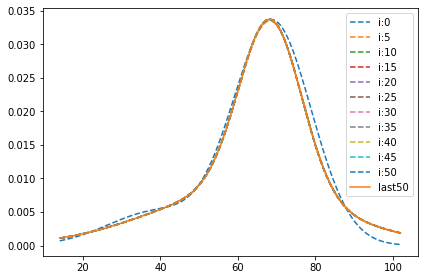

In [15]:
# 50回繰り返す
for i in sp.arange(50+1):
    # Estep
    # responsibilityの更新 
    # responsibility = EStep(k_size, y, lambda_vec, mu_vec, sigma2_vec)
    responsibility = EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, coef_vec, sigma2_vec = MStep(k_size, responsibility, y)
    #mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
    
    if i % 5 == 0:
        print("i:", i, "lambda", lambda_vec, "mu", mu_vec, "sigma2", sigma2_vec)
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


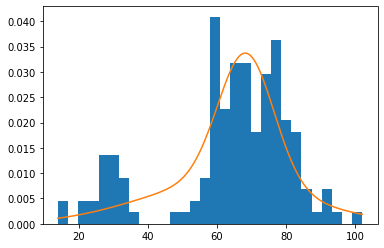

In [16]:
plt.hist(y, bins=30, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

#### 注  
- mu1, mu2は反転する可能性があるため、f1, f2の混合比率を確認

In [17]:
print("f1の混合比率", lambda_vec[0])
print("mu1", mu_vec[0])
print("sigma1", sigma2_vec[0])

print("f2の混合比率", lambda_vec[1])
print("mu2", mu_vec[1])
print("sigma2", sigma2_vec[1])

f1の混合比率 0.4777329378883163
mu1 61.39587246161076
sigma1 564.0994781989309
f2の混合比率 0.5222670621116837
mu2 68.37250451560294
sigma2 64.12313866696367


###  推定された分布の可視化

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.00069307, 0.00267328, 0.01194727, 0.02996717, 0.04650193,
        0.04300356, 0.02702986, 0.00831688, 0.00194721, 0.00026403]),
 array([39.98794187, 45.79028196, 51.59262206, 57.39496215, 63.19730224,
        68.99964234, 74.80198243, 80.60432252, 86.40666261, 92.20900271,
        98.0113428 ]),
 <a list of 10 Patch objects>)

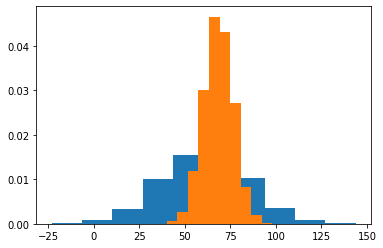

In [18]:
# 推定された分布の可視化
new_N1 = stats.norm(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

# rvs (Random variates) 確率変数
new_s1 = new_N1.rvs(size=int(lambda_vec[0]*10000))
new_s2 = new_N2.rvs(size=int(lambda_vec[1]*10000))


#plt.hist(y, bins=30, density=True)

plt.hist(new_s1, density=True)
plt.hist(new_s2, density=True)


### # 推定されたパラメータ

In [19]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept", "hf", "pop",  "urb", "gdp","dist", "air", "detection"], columns=["早期感染国"])
res_df["晩期感染国"] = coef_vec[1].round(4)
res_df

,早期感染国,晩期感染国
Intercept,61.3959,68.3725
hf,-2.3595,-0.9461
pop,-2.2006,-6.3430
urb,-3.5734,-3.7705
gdp,-1.7204,-1.4727
dist,9.6617,1.3979
air,-2.2014,2.8427
detection,-6.7643,-1.9969


In [20]:
# 初期値パラメータ
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,21.790,93.920
hf,0.994,-0.915
pop,0.000,0.000
urb,-0.014,-0.213
gdp,0.000,0.000
dist,0.000,0.000
air,0.000,0.000
detection,-0.124,-0.116


# 改善事項  
- p値  
- 信頼区間  
- AIC  
  
  
- 対数化しない場合  
- 変数選択  
- f1とf2で変数を帰る